# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import nltk
import gensim
import seaborn as sns #Makes the graphics look nicer

import matplotlib.cm

import copy


#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
For my final project I intend to analyze a corpus of ‘letters to the shareholder’ from the annual reports of Dow Jones companies for at least a span of 10 years. I am interested in how CEOs (and their PR team) advertise their company to investors, including how this changes over time. From what I’ve learned so far (using techniques from our seminar), there may be three ‘groupings’ discussed in the letter: markets & business, personal relationships (i.e. communities, customers, employees), and financial returns (dividends, buy backs, growth). I’m particularly interested in how firms advertise social responsibility to respective stakeholders.

## ***Why?***
Firm communication with their stakeholders is vital to the success of it’s business. When firms lose investors, customers, employees, or the support of the community, business is hard. CEOs use these letters to convey future plans and finding patterns in this data could provide information on firm decisions and also clarify what constitutes successful advertising in a letter. As an aside: if an effective measurement of advertised corporate social responsibility (CSR) can be created, it could provide a unique correlation between advertised and actual CSR.

## ***How?***
I currently have approximately 120 letters in a text corpus. Before the end of the course, I hope to have all Dow Jones Letters to the Shareholder between 2000 and 2015 (30 companies in Dow Jones, 15 years, 450 letters total). I have not yet found a dataset compiling these letters to shareholders. The majority are stored in the annual reports for each company either on their website or in databases (Mergent Online). I need to manually select the pages from the annual report pdfs that comprise the letter, then feed them through my program that scrapes text (using the package provided in class if in the proper format, otherwise using a work-around that uses Pytesseract and OCR to read the text, which is not optimal). In this course, I’m trying to find the best methods to capture topics within letters. The clustering methods may provide some insight. Word Embeddings could clarify how these letters change over time & across industry. I’m also trying to develop interesting spectrums so Word2Vec models could describe interesting context.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
I am very unsatisfied with my sample. As described in the ‘How’ section above, the letters are arduous to collect. I fear the sample size is actually too small to uncover any social game at work. That’s why I collect more letters regularly and hope to have the entire Dow Jones dataset compiled before the final presentation. Even then, the dataset should provide a limited reveal: Dow Jones companies are simply large publicly owned companies, which isn’t the best measurement to uncover social norms. These letters obviously do not reflect general firm decisions or public relations. Some letters are short and to the point, others (ie JPMorgan Chase) are incredibly large.  Yet, hopefully they provide interesting insight. If they do, we could launch a much larger study (possibly on Fortune 500 letters, etc.).

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

# K-means clustering

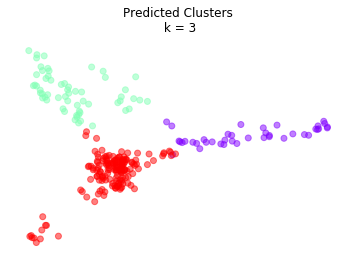

In [17]:
#I'm planning on using MTurk to classify the data, but here are three methods we've used to create possible interesting subsamples of my corpus

#clustering
df = pandas.read_pickle('C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\2-Corpus-Linguistics\\pandasDF.pkl')
df.head()

#k-means provides clustering, MTurk could provide insight on what these documents describe
targetDF = df
textColumn = 'text'
numCategories = 3
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

# Topic Modeling

In [30]:
#topic modeling could provide a clearer analysis, but MTurk would be able to assess each of the topics more clearly than a computer

#Apply our functions
df['tokenized_text'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
df[::100]

,company,text,year,tokenized_text,normalized_tokens,reduced_tokens
0,3M Letter,dear shareholder:\n\nthanks to the hard work o...,2000,"[dear, shareholder, :, thanks, to, the, hard, ...","[dear, sharehold, thank, hard, work, ofthouszm...","[dear, sharehold, thank, hard, deliv, solid, g..."
100,Johnson and Johnson Letter,chairmanâs letter\n\nto our\nshareholders\n\...,2010,"[chairmanâs, letter, to, our, shareholders, ...","[letter, sharehold, rememb, aycar, compani, se...","[sharehold, test, th, continu, hallmark, johns..."
200,Johnson and Johnson,I am often asked what led me to work in healt...,2014,"[I, am, often, asked, what, led, me, to, work,...","[often, ask, led, work, health, care, whi, cho...","[ask, led, health, care, chose, spend, career,..."


# Linguistic Change

In [32]:

senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(df['text'])



In [33]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

df['reduced_tokens'] = df['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [34]:
dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])

In [35]:
corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]

In [36]:
gensim.corpora.MmCorpus.serialize('letter.mm', corpus)
letmm = gensim.corpora.MmCorpus('letter.mm')

In [37]:
letterlda = gensim.models.ldamodel.LdaModel(corpus=letmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [38]:
letter1Bow = dictionary.doc2bow(df['reduced_tokens'][0])
letter1lda = letterlda[letter1Bow]
print("The topics of the company: {}".format(df['company'][0])+ 'in year: {}'.format(df['year'][0]))
print("are: {}".format(letter1lda))

The topics of the company: 3M Letter in year: 2000
are: [(0, 0.34782225), (3, 0.18813011), (6, 0.4595155)]


In [39]:
letterldaDF = pandas.DataFrame({
        'company' : df['company'],
        'topics' : [letterlda[dictionary.doc2bow(l)] for l in df['reduced_tokens']]
    })

In [40]:
#Dict to temporally hold the probabilities
lettertopicsProbDict = {i : [0] * len(letterldaDF) for i in range(letterlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(letterldaDF['topics']):
    for topicNum, prob in topicTuples:
        lettertopicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(letterlda.num_topics):
    letterldaDF['topic_{}'.format(topicNum)] = lettertopicsProbDict[topicNum]

letterldaDF[1::100]

,company,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,Alcoa Letter,"[(3, 0.68250006), (6, 0.3135812)]",0.000000,0.000000,0.0,0.6825,0.000000,0.0,0.313581,0.000000,0.0,0.000000
101,JP Morgan and Chase Letter,"[(0, 0.036608603), (1, 0.040364586), (4, 0.052...",0.036609,0.040365,0.0,0.0000,0.052608,0.0,0.841073,0.024154,0.0,0.000000
201,JPMorgan Chase,"[(1, 0.010319605), (6, 0.93635505), (7, 0.0307...",0.000000,0.010320,0.0,0.0000,0.000000,0.0,0.936355,0.030738,0.0,0.010989


In [44]:
#Perhaps MTurk could provide reasoning as to why certain years are more similar for specific words:

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        v1 = embeddingsDict[cats[0]][0][word]
        v2 = embed[word]
        
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(v1, axis = 0),np.expand_dims(v2, axis =0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            v1 = embeddingsDict[cat][0][word]
            v2 = embed[word]
            cs = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(v1, axis = 0),np.expand_dims(v2, axis =0))
            dists[cat].append(np.abs(1 - cs[0,0]))
    return pandas.DataFrame(dists, index = cats)



In [47]:
#remove stop words while preserving sentence structure
df['tokenized_sents'] = df['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

In [49]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


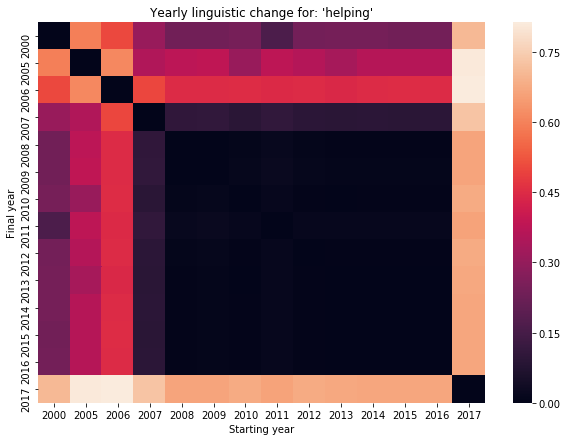

In [52]:
raw, comp = compareModels(df,'year')
                            
targetWord = 'helping'

pltDF = getDivergenceDF(targetWord, comp)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [54]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])


Interrogate the AnnotationsContainer object.

In [90]:
print(x)

[[ 2.  3.  4. ... -1. -1. -1.]
 [ 1.  1.  1. ... -1. -1. -1.]
 [ 3.  3.  2. ... -1. -1. -1.]
 ...
 [ 3.  3. -1. ... -1. -1.  2.]
 [ 3.  3. -1. ... -1. -1.  4.]
 [ 2.  2. -1. ... -1. -1.  1.]]


In [4]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [5]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [6]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [7]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


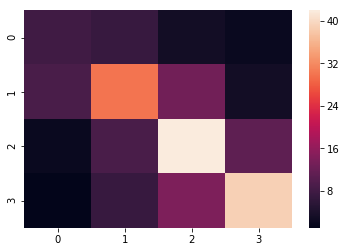

In [8]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [9]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [10]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [11]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [12]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [13]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


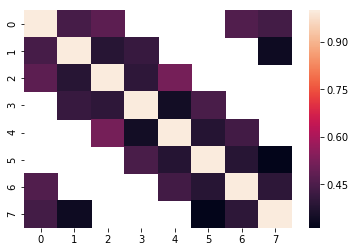

In [14]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [15]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [16]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [17]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

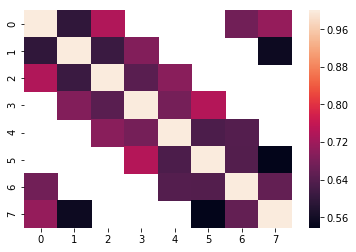

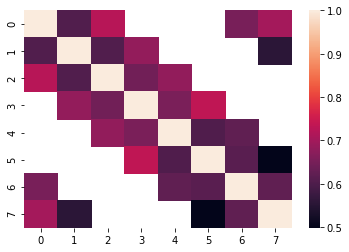

In [18]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [19]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

Using MTurk, I provided paragraphs from multiple 'letters to the shareholder' and asked the question: Does this paragraph contain some context perceived to be referencing 'Corporate Social Responsibility.' There were 70 paragraphs, results are below. I conducted 2 of the same survey: once with two workers reporting for each paragraph, and the second with only one worker reporting for each paragraph. After cleaning the data (see the dataframe 'clean' below), I have 59 paragraphs categorized as pertaining to social responsibility on behalf of the firm or not (by 3 separate workers).

Note: with the 59 paragraphs categorized in the 'clean' dataframe, none of the workers categorized a paragraph more than once (no repeats among worker categorization). However, in neither survey did a worker complete a categorization for the entire sample I provided. This would create some difficulty in measuring inter-coder agreement and covariation. Therefore, for the study undertaken in this homework assignment, I am treating each survey as if they were conducted by a separate worker (ie I am studying inter-survey agreement).

In [5]:
survey1 = pandas.read_csv("C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\5-Reliability\\Batch_3101079_batch_results.csv")

In [6]:
survey1

,HITID,Company,Year,Text,Worker,Answer,Date
0,3MNJFORX8B2ZVXWWN6N7H679YENF5A,Microsoft,2013,We have seen incredible results in the past de...,A1DCGB72N1UIPT,No Social Responsibility,2018-02-03 22:38:35 UTC
1,34YWR3PJ288H0C1GQUNH6IBPLB8X0Y,Microsoft,2016,Microsoft is uniquely positioned in this era o...,A1DCGB72N1UIPT,No Social Responsibility,2018-02-03 22:38:30 UTC
2,3R16PJFTS3PSF0KAACVUSRT06EA4KX,CocaCola,2014,"At the same time, we refused to let tough cond...",A2B6WQG0A9CKXQ,Social Responsibility,2018-02-03 22:38:42 UTC
3,3R868ACW4SA3GBCG5E05OVEG0SVZG0,McDonalds,2016,To continue growing the business for the long ...,A3RYI5HXC2MJLN,{},2018-02-03 22:38:50 UTC
4,3UV0D2KX1MHHZESW914XCE1VYISF45,Microsoft,2013,Last year in my letter to you I declared a fun...,ATHS9CW2FLYUY,Social Responsibility,2018-02-03 22:39:17 UTC
5,359AP8GAGGI7FPQ5KXC37K02S7R7C7,Microsoft,2013,"Third, in September, we also announced a new s...",ATHS9CW2FLYUY,No Social Responsibility,2018-02-03 22:39:10 UTC
6,3KI0JD2ZU1GIZ8H4A6Z0LK8SWLG76F,Microsoft,2016,I’m proud of the progress we’ve made as a comp...,ATHS9CW2FLYUY,No Social Responsibility,2018-02-03 22:39:13 UTC
7,3YD0MU1NC2ZJMAT70JGC1PAES467A5,Microsoft,2013,This past year we took the first big bold step...,A2FUMA4UR6S920,No Social Responsibility,2018-02-03 22:39:29 UTC
8,3VP28W7DUNIX2BGLUUUN6AE4ZDVZF1,McDonalds,2016,Stronger customer perceptions of McDonald’s he...,A3RYI5HXC2MJLN,No Social Responsibility,2018-02-03 22:39:37 UTC
9,3R0WOCG21M7JIS8FX10P1IW4LI0UDW,McDonalds,2015,"Throughout 2015, we evaluated opportunities to...",ATHS9CW2FLYUY,No Social Responsibility,2018-02-03 22:39:50 UTC


In [7]:
survey2 = pandas.read_csv("C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\5-Reliability\\Batch_3101112_batch_results.csv")

In [8]:
survey2

,HITID,Company,Year,Text,Worker1,Answer1,Worker2,Answer2,Agreement,Answer,Date
0,3KWGG5KP6J0Q0SXSO3ESQ2XSNWOMCZ,CocaCola,2015,"In emerging markets, we focused on volume and ...",A2LCFORIW0NF1S,no social responsibility,A3BL2ZEODD79AZ,social responsibility,No,no_agreement,2018-02-04 00:10:58 UTC
1,30ZKOOGW2W45BOE5B3Z30FJ1PI8A1D,CocaCola,2014,"While this transformation began early in 2014,...",A2QLSHXNCHBRN4,no social responsibility,A3BI0AX5T5GVO3,no social responsibility,Yes,no social responsibility,2018-02-04 00:11:36 UTC
2,32FESTC2NHO9D021X55EHCEM0IRCUH,CocaCola,2015,"Third, we became more efficient and productive...",A3F0NFNLOLFJT0,no social responsibility,A3BI0AX5T5GVO3,social responsibility,No,no_agreement,2018-02-04 00:10:28 UTC
3,3126F2F5F81BITEJCACFXURQDDCPER,McDonalds,2016,Stronger customer perceptions of McDonald’s he...,A3BI0AX5T5GVO3,no social responsibility,AKSJ3C5O3V9RB,no social responsibility,Yes,no social responsibility,2018-02-04 00:12:49 UTC
4,3AJA9FLWSCWB7LRBUQ616FBE30WFIN,McDonalds,2015,We recommitted to running great restaurants an...,A2CJFO19NY4T5R,no social responsibility,A3BI0AX5T5GVO3,social responsibility,No,no_agreement,2018-02-04 00:11:58 UTC
5,3LB1BGHFL2U7GQOHTSXT97K3KS2TYF,CocaCola,2015,We also announced that we expect to meet our g...,A2CJFO19NY4T5R,social responsibility,A2QLSHXNCHBRN4,social responsibility,Yes,social responsibility,2018-02-04 00:11:00 UTC
6,3MJ9GGZYO34C09W1U7ZH5YT6HOMA2U,Microsoft,2013,"First, we are well underway in implementing th...",A1APYLD4DUK33J,no social responsibility,A2CJFO19NY4T5R,no social responsibility,Yes,no social responsibility,2018-02-04 00:12:52 UTC
7,3RWSQDNYL9KRXUPLTI0G3IYMN84FFW,CocaCola,2014,"Globally, families and individuals spent less ...",A1APYLD4DUK33J,no social responsibility,A2QLSHXNCHBRN4,no social responsibility,Yes,no social responsibility,2018-02-04 00:10:54 UTC
8,3P520RYKCH4OEFTMIVI6368C815U5R,McDonalds,2015,"Throughout 2015, we evaluated opportunities to...",A2LCFORIW0NF1S,no social responsibility,A2QLSHXNCHBRN4,no social responsibility,Yes,no social responsibility,2018-02-04 01:11:57 UTC
9,391JB9X4ZY68JQ9GGGVQELA0S5XMKC,Microsoft,2013,We have seen incredible results in the past de...,A1ZRK6K5JUPJAV,no social responsibility,A2N7I0331X72Z7,no social responsibility,Yes,no social responsibility,2018-02-04 00:11:51 UTC


In [9]:
clean = pandas.read_csv("C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\5-Reliability\\clean.csv")

In [10]:
clean

,company,year,text,worker1,worker2,worker3,social1,social2,social3
0,CocaCola,2014,About half of these savings will come from bei...,A2CJFO19NY4T5R,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,1,0
1,Microsoft,2013,"As I think about whatâs ahead, Iâm incredi...",A3F0NFNLOLFJT0,A3IL3HGJW7K6Q1,A3RYI5HXC2MJLN,0,1,0
2,Microsoft,2016,Commercial cloud annualized revenue run rate e...,A2QLSHXNCHBRN4,A2WGW5Y3ZFBDEC,A3RYI5HXC2MJLN,0,0,0
3,McDonalds,2016,Customers noticed the changes we made. As of l...,A2CJFO19NY4T5R,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,0,0
4,CocaCola,2014,"Fact is, weâre competing in a historically s...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A166A2M31CW2C7,0,0,0
5,CocaCola,2014,"Fifth,Â we beganÂ streamlining and simplifying...",A2CJFO19NY4T5R,A3BL2ZEODD79AZ,A3RYI5HXC2MJLN,0,1,0
6,Microsoft,2013,"First, we are well underway in implementing th...",A1APYLD4DUK33J,A2CJFO19NY4T5R,A3RYI5HXC2MJLN,0,0,0
7,CocaCola,2015,"First, we said we would establishÂ clear portf...",A2WGW5Y3ZFBDEC,AOHE56L0POV6,A8TIL9U6YHG5,0,0,1
8,CocaCola,2014,"First,Â we are makingÂ targeted, disciplined i...",A2WGW5Y3ZFBDEC,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0
9,CocaCola,2014,"Fourth,Â we aggressively stepped up ourÂ produ...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0


Understanding validity of MTurk worker categorizations:

In [11]:
paragraph = []
responsibility = []

for index,row in clean.iterrows():
    r = [row['social1'],row['social2'],row['social3']]
    paragraph.append(row['text'])
    responsibility.append(r)

In [12]:
anno = AnnotationsContainer.from_array(responsibility, missing_values=[-1])

In [13]:
anno.annotations

array([[ 0,  1,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  1],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  1],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 1,  1,  0],
       [ 0,  0, -1],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 1,  1,  1],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  1,  1],
       [ 0,  1,  0],
       [ 1,  1,  1],
       [ 0,  1,  1],
       [ 0,  0,  0],
       [ 1,  1,  1],
       [ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  

In [14]:
anno.labels

[0, 1]

In [15]:
anno.missing_values

[-1]

In [16]:
pyanno.measures.agreement.labels_frequency(anno.annotations,2)

array([0.77456647, 0.22543353])

Confusion Matrix

[[35. 19.]
 [ 0.  4.]]


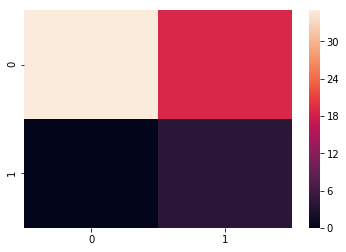

In [17]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],2)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [18]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.08281315022888046

In [19]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 


In [20]:
pairwise_metric_average(cohens_kappa, anno.annotations)

0.19509444688175379

In [21]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.20260492040520978

In [22]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.19509444688175379

I am not convinced about the accuracy of the surveys as predicted by Scotts Pi or Cohens Kappa (above). With only 3 surveys and 59 paragraphs measured, I believe the dataset to be too small to provide an accurate assessment. That being said, the confusion matrix provided some insight as surveys were much more likely to agree on 'no social responsibility' (although, there were many more indications of 'no social responsibility' than 'social responsibility').

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [20]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.84091168 0.04807754 0.09106314 0.01994764]
  [0.29469413 0.51651819 0.10110265 0.08768504]
  [0.01434698 0.15113543 0.70864909 0.1258685 ]
  [0.0627034  0.08702336 0.20949051 0.64078274]]

 [[0.65950668 0.16673911 0.10495052 0.06880369]
  [0.22980049 0.48679111 0.23661053 0.04679787]
  [0.02614807 0.12546474 0.73376542 0.11462178]
  [0.1055432  0.18316521 0.16446253 0.54682906]]

 [[0.84019253 0.08084558 0.07736752 0.00159437]
  [0.04797626 0.67904748 0.16192605 0.11105021]
  [0.10840333 0.1009008  0.66032378 0.13037209]
  [0.01501469 0.12910269 0.14206592 0.7138167 ]]

 [[0.49515931 0.16512294 0.28666395 0.0530538 ]
  [0.21024395 0.54026729 0.13859602 0.11089274]
  [0.10094024 0.14134997 0.62629332 0.13141646]
  [0.08628236 0.06991683 0.12126977 0.72253105]]

 [[0.77922514 0.16998773 0.04323361 0.00755353]
  [0.16074846 0.65503154 0.05426848 0.12995152]
  [0.0251411  0.10194201 0.74331629 0.1296006 ]
  [0.04101757 0.11437762 0.1521566  0.69244822]]

 [[0.4118118  0.41289957 0.101

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [21]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [22]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Uncomment the cell below if you would rather train by MLE.

In [23]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [24]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [25]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x294b4efc550>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x294b506e198>,
  <matplotlib.axes._subplots.AxesSubplot at 0x294b55960f0>))

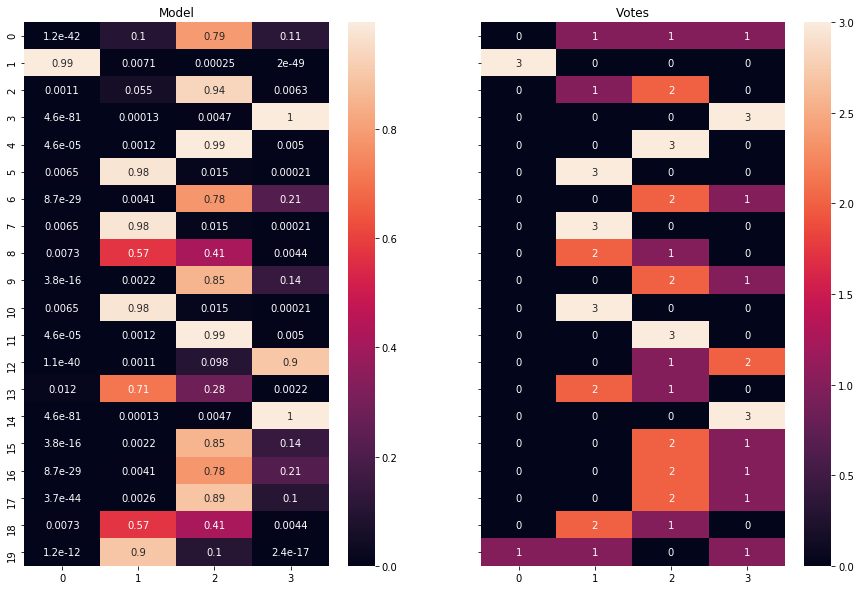

In [26]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [27]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.7621305  0.69691384 0.89373705 0.65076261 0.60212387 0.8624062
 0.60396069 0.7990435 ]
-3305.4257507294765


In [28]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79118453 0.74069662 0.76227478 0.72512732 0.71641487 0.7186117
 0.77311881 0.71674531]
-2811.945970211904


In [29]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.79118453, 0.74069662, 0.76227478, ..., 0.7186117 , 0.77311881,
        0.71674531],
       [0.79118453, 0.74069662, 0.76227478, ..., 0.7186117 , 0.77311881,
        0.71674531],
       [0.79118453, 0.74069662, 0.76227478, ..., 0.7186117 , 0.77311881,
        0.71674531],
       ...,
       [0.73542978, 0.70751399, 0.79572994, ..., 0.67549231, 0.77154369,
        0.70125471],
       [0.73808411, 0.70492053, 0.81033859, ..., 0.73118233, 0.77261869,
        0.7117085 ],
       [0.79680796, 0.73162596, 0.78677218, ..., 0.69675519, 0.79145028,
        0.65376831]])

In [30]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01110983 0.28914574 0.36499348 0.33475095]
 [0.9902188  0.00241967 0.00405143 0.0033101 ]
 [0.00250255 0.05512056 0.93453827 0.00783863]
 ...
 [0.00253198 0.04400909 0.94552812 0.0079308 ]
 [0.00249687 0.00571701 0.93241682 0.0593693 ]
 [0.03195115 0.93872903 0.01613621 0.01318361]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x294b4edacf8>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x294b5ab4f28>,
  <matplotlib.axes._subplots.AxesSubplot at 0x294b5d16f60>))

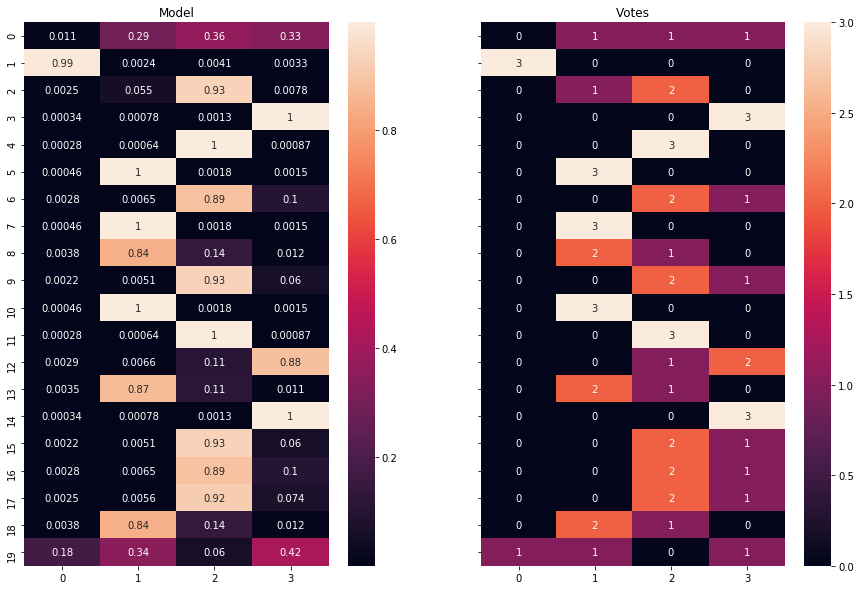

In [31]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [33]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

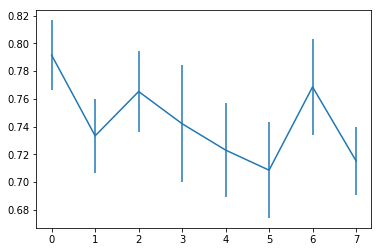

In [34]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [35]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [36]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

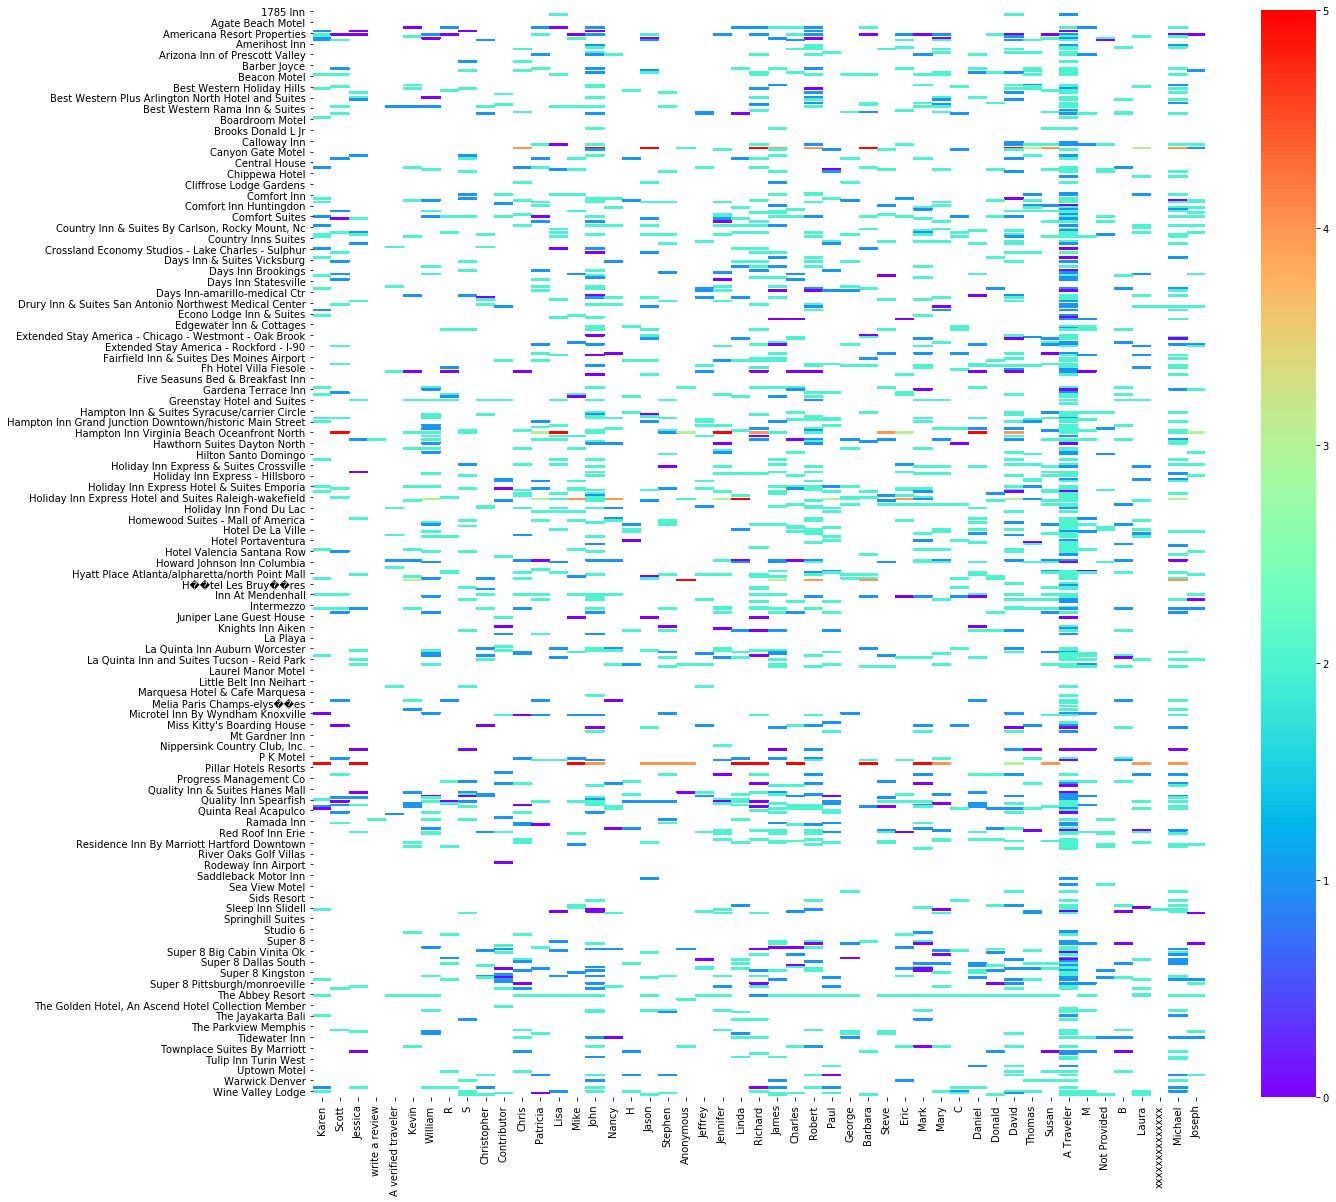

In [37]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [38]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [39]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [40]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [41]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [42]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


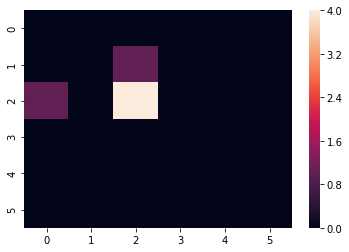

In [43]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [44]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [45]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [46]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\pyanno\measures\helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


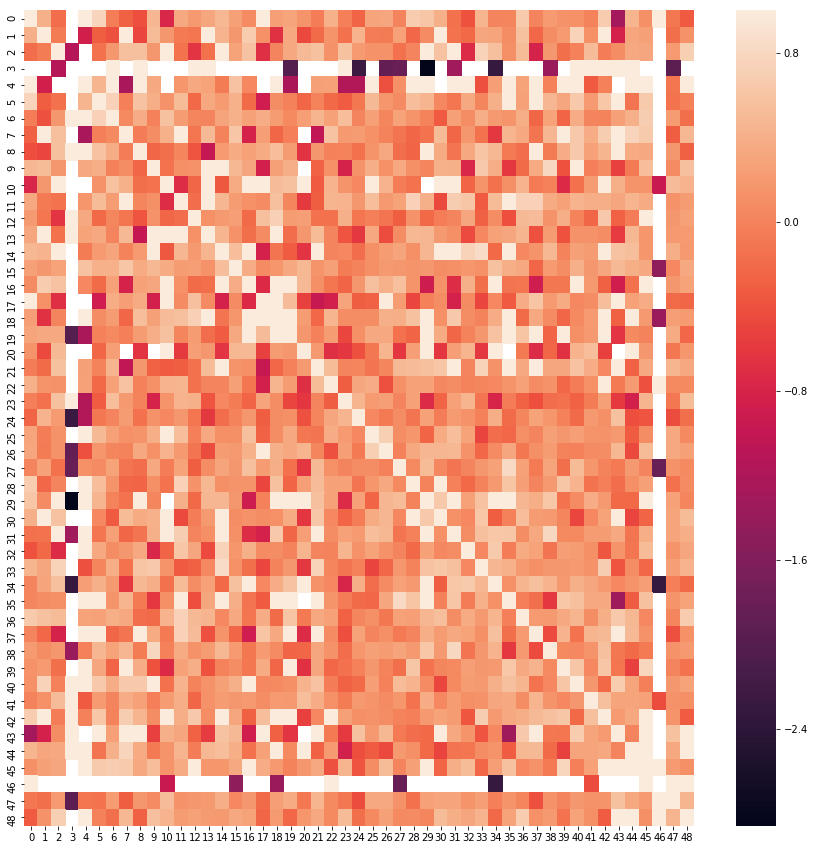

In [47]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [48]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

-2706.218566927804


(<matplotlib.figure.Figure at 0x294b52a2da0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x294b7561ef0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x294b75be438>))

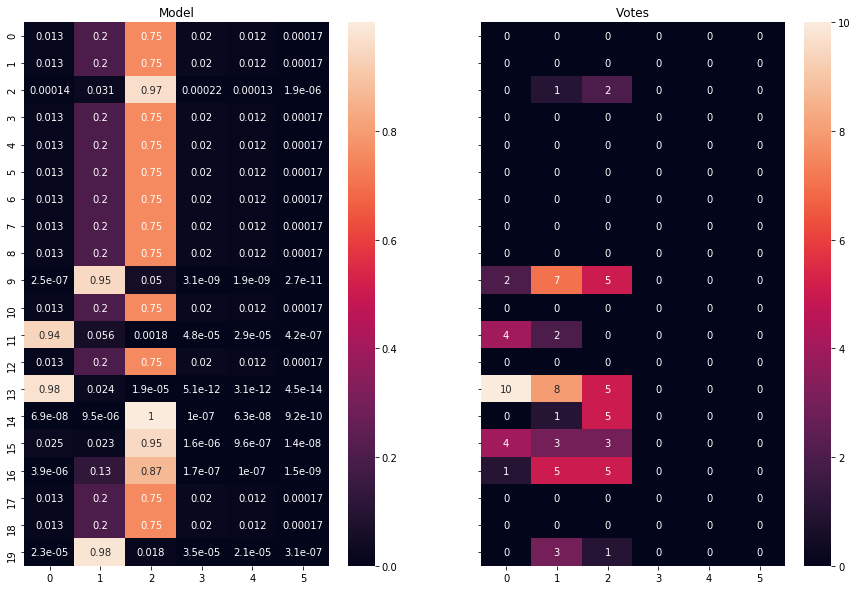

In [49]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

In [23]:
# create a new instance of model B, with 2 label classes and 3 annotators.
model2 = ModelBt.create_initial_state(2, 3)
print(model2.theta)
print(model2.log_likelihood(anno.annotations))

[0.79746438 0.66868728 0.6272186 ]
-140.56471578715622


In [24]:
sample2 = model2.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [25]:
model2.map(anno.annotations)
print(model2.theta)
print(model2.log_likelihood(anno.annotations))

[0.99999994 0.67797327 0.82759166]
-77.71488370853722


In [26]:
posterior2 = model2.infer_labels(anno.annotations)
print(posterior2)

[[9.99999998e-01 1.84432724e-09]
 [9.99999998e-01 1.84432724e-09]
 [1.00000000e+00 4.16099016e-10]
 [1.00000000e+00 4.16099016e-10]
 [1.00000000e+00 4.16099016e-10]
 [9.99999998e-01 1.84432724e-09]
 [1.00000000e+00 4.16099016e-10]
 [9.99999990e-01 9.58765357e-09]
 [1.00000000e+00 4.16099016e-10]
 [1.00000000e+00 4.16099016e-10]
 [1.00000000e+00 4.16099016e-10]
 [1.00000000e+00 4.16099016e-10]
 [9.99999998e-01 1.84432724e-09]
 [9.99999990e-01 9.58765357e-09]
 [1.00000000e+00 4.16099016e-10]
 [9.99999998e-01 1.84432724e-09]
 [1.00000000e+00 4.16099016e-10]
 [1.00000000e+00 4.16099016e-10]
 [9.99999998e-01 1.84432724e-09]
 [9.99999990e-01 9.58765357e-09]
 [9.99999998e-01 1.84432724e-09]
 [1.00000000e+00 4.16099016e-10]
 [9.99999998e-01 1.84432724e-09]
 [1.75016346e-06 9.99998250e-01]
 [9.99999998e-01 1.99735156e-09]
 [1.00000000e+00 4.16099016e-10]
 [9.99999998e-01 1.84432724e-09]
 [1.00000000e+00 4.16099016e-10]
 [9.99999998e-01 1.84432724e-09]
 [1.00000000e+00 4.16099016e-10]
 [1.000000

In [27]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x1f7381f53c8>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1f73a202630>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f73a2fd2e8>))

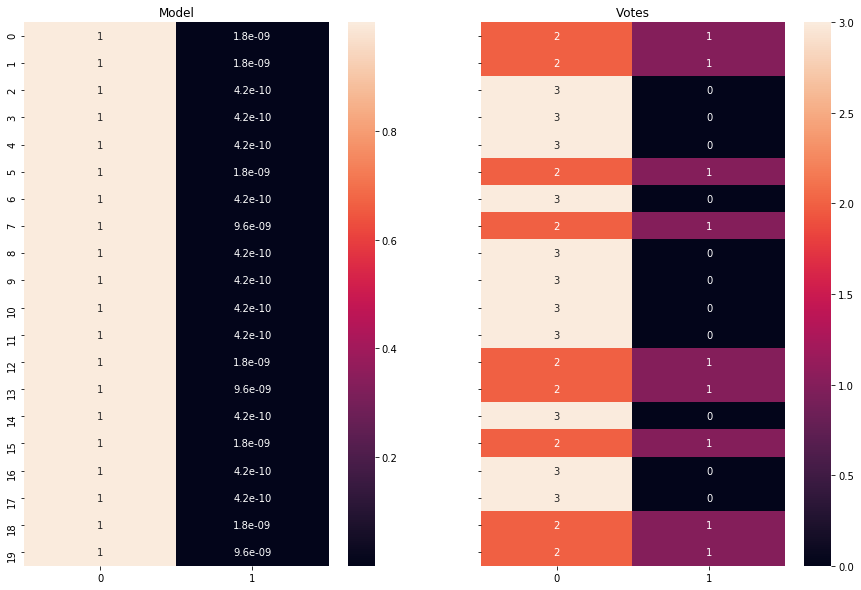

In [28]:
makeQuestionComparison(model2, anno)

The model predicts that there is 'no social responsibility' in every paragraph provided (for at least the first 20 samples). This likely results from a small sample size (relative to the much smaller group of 'social responsibility' categorized paragraphs), which doesn't allow the true signal to be measured. But lets continue with the model B

In [29]:
# create a new instance of model B, with 2 label classes and 3 annotators.
modelB2 = ModelBt.create_initial_state(2, 3)
print(modelB2.theta)
print(modelB2.log_likelihood(anno.annotations))

[0.81466488 0.88729153 0.80450246]
-154.16518741936792


In [30]:
modelB2.map(anno.annotations)
print(modelB2.theta)
print(modelB2.log_likelihood(anno.annotations))

[0.99999995 0.67828094 0.8274018 ]
-77.71512902293125


In [31]:
modelB2.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.981235  , 0.72522043, 0.82788137],
       [0.97634618, 0.70494384, 0.80079577],
       [0.95573366, 0.7566189 , 0.88840129],
       [0.98821611, 0.64949153, 0.82425488],
       [0.99862109, 0.71132412, 0.71154715],
       [0.99862109, 0.71132412, 0.71154715],
       [0.99862109, 0.71132412, 0.71154715],
       [0.97045974, 0.5984788 , 0.79021168],
       [0.95457221, 0.67405931, 0.86952959],
       [0.95457221, 0.67405931, 0.86952959],
       [0.98276055, 0.71885112, 0.86427456],
       [0.97922423, 0.7848629 , 0.89960568],
       [0.95177083, 0.66526786, 0.81891   ],
       [0.97659344, 0.74723936, 0.79723975],
       [0.97659344, 0.74723936, 0.79723975],
       [0.97333873, 0.65654779, 0.81330645],
       [0.97333873, 0.65654779, 0.81330645],
       [0.97441001, 0.6317123 , 0.86263815],
       [0.99717636, 0.65258767, 0.76016475],
       [0.99290047, 0.6484347 , 0.8294129 ],
       [0.99290047, 0.6484347 , 0.8294129 ],
       [0.98876122, 0.71276378, 0.87889348],
       [0.

In [32]:
posterior = modelB2.infer_labels(anno.annotations)
print(posterior)

[[9.99999998e-01 1.68676216e-09]
 [9.99999998e-01 1.68676216e-09]
 [1.00000000e+00 3.79479390e-10]
 [1.00000000e+00 3.79479390e-10]
 [1.00000000e+00 3.79479390e-10]
 [9.99999998e-01 1.68676216e-09]
 [1.00000000e+00 3.79479390e-10]
 [9.99999991e-01 8.72064461e-09]
 [1.00000000e+00 3.79479390e-10]
 [1.00000000e+00 3.79479390e-10]
 [1.00000000e+00 3.79479390e-10]
 [1.00000000e+00 3.79479390e-10]
 [9.99999998e-01 1.68676216e-09]
 [9.99999991e-01 8.72064461e-09]
 [1.00000000e+00 3.79479390e-10]
 [9.99999998e-01 1.68676216e-09]
 [1.00000000e+00 3.79479390e-10]
 [1.00000000e+00 3.79479390e-10]
 [9.99999998e-01 1.68676216e-09]
 [9.99999991e-01 8.72064461e-09]
 [9.99999998e-01 1.68676216e-09]
 [1.00000000e+00 3.79479390e-10]
 [9.99999998e-01 1.68676216e-09]
 [1.59266865e-06 9.99998407e-01]
 [9.99999998e-01 1.81914950e-09]
 [1.00000000e+00 3.79479390e-10]
 [9.99999998e-01 1.68676216e-09]
 [1.00000000e+00 3.79479390e-10]
 [9.99999998e-01 1.68676216e-09]
 [1.00000000e+00 3.79479390e-10]
 [1.000000

(<matplotlib.figure.Figure at 0x1f73a30f898>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1f73a6c2fd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f73a7f4eb8>))

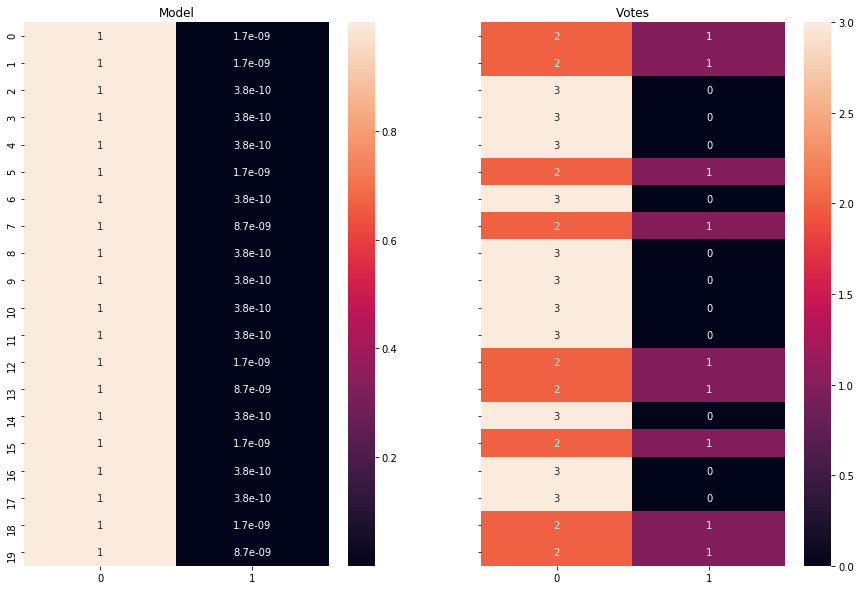

In [33]:
makeQuestionComparison(modelB2, anno)

In [34]:
#Coder Accuracy
model = ModelBt.create_initial_state(2,3)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

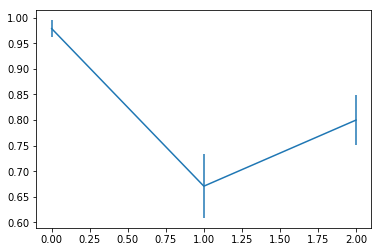

In [35]:
plt.figure()
plt.errorbar(range(3),y, yerr = y_ci)
plt.show()

This indicates that survey '1' is much more innacurate than either survey '0' or survey '2.' But as mentioned before, I think doubt the veracity of this model because my original dataset only has 59 data points and the signal (social responsibillity) is relatively rare. Therefore, I believe the model overestimates a 'no social responsibility' selection, which is why the first survey (survey '0') is ranked so highly in accuracy.

In [ ]:
#Need more data!